# PURPOSE

In [ ]:
'''
use bottom-up approach
'''
None

# IMPORTS

In [3]:
%run ipynb_setup.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%run class_def.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GET DATA

In [6]:
d=Dataset()
df_num = d.df.select_dtypes(include=['int64','float64'])
df_num

,price,retail_price,units_sold,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,merchant_rating_count,merchant_rating
0,16.00,14,100,3.76,54,26.0,8.0,10.0,1.0,9.0,568,4.128521
1,8.00,22,20000,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,17752,3.899673
2,8.00,43,100,3.57,14,5.0,4.0,2.0,0.0,3.0,295,3.989831
3,8.00,8,5000,4.03,579,295.0,119.0,87.0,42.0,36.0,23832,4.020435
4,2.72,3,100,3.10,20,6.0,4.0,2.0,2.0,6.0,14482,4.001588
...,...,...,...,...,...,...,...,...,...,...,...,...
1565,3.00,8,100,3.79,57,25.0,10.0,13.0,3.0,6.0,4080,3.987990
1567,8.00,7,20000,4.25,3127,1919.0,580.0,304.0,128.0,196.0,16803,4.155032
1568,6.00,9,10000,4.08,1367,722.0,293.0,185.0,77.0,90.0,5316,4.224605
1570,5.00,19,100,3.71,59,24.0,15.0,8.0,3.0,9.0,210,3.961905


# REPEAT WITH PIPELINE

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV

In [51]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch

### [figure out best `k` to use] Impute + StandardScaler (+ MinMaxScaler)

In [37]:
# pipeline
pl = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), # PCA can't have nans
    StandardScaler(), # apply standard scaler first, PCA super sensitive to scaling
    #MinMaxScaler(feature_range=(-1,1)), # consider apply minmax scaler on 1 sd of the data as well smooth outliers
)
reduced = pl.fit_transform(df_num)

In [34]:
ac=AgglomerativeClustering(memory='mycachedir',compute_full_tree=True)

In [35]:
ac.fit(reduced)

AgglomerativeClustering(compute_full_tree=True, memory='mycachedir')

In [36]:
ac

AgglomerativeClustering(compute_full_tree=True, memory='mycachedir')

In [33]:
pd.Series(ac.labels_).unique()

array([0, 1], dtype=int64)

In [27]:
ac.plot()

AttributeError: 'AgglomerativeClustering' object has no attribute 'plot'

In [22]:
classifier = GridSearchCV(
    ac,
    {n_clusters : range(2,6)},
    scoring = 'adjusted_rand_score',
    n_jobs=-1,
    verbose=2,
)
classifier.fit(reduced)

NameError: name 'n_clusters' is not defined

In [7]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model.fit(reduced)
labels = model.labels_

In [11]:
pd.Series(labels).value_counts()

1    661
4    283
2    208
3    139
0     50
dtype: int64

### [figure out best `k` to use] Impute + StandardScaler + MinMaxScaler + PCA

<AxesSubplot:>

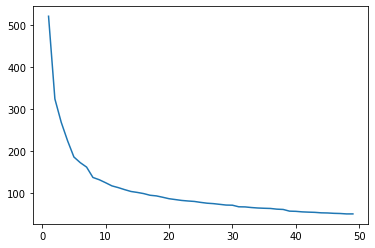

In [60]:
# pipeline
pl = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), # PCA can't have nans
    StandardScaler(), # apply standard scaler first, PCA super sensitive to scaling
    MinMaxScaler(feature_range=(-1,1)), # consider apply minmax scaler on 1 sd of the data as well smooth outliers
    PCA(n_components=5),
)

reduced = pl.fit_transform(df_num)

# A list holds the SSE values for each k
sse     = {}
k_range = range(1, 50) 
for k in k_range:
    kmeans = KMeans(
        init         = "random",
        n_clusters   = k, 
        n_init       = 10,
        max_iter     = 300,
        random_state = 42
    )
    kmeans.fit(reduced)
    sse[k] = kmeans.inertia_

pd.Series(sse).plot()